In [2]:
# -*- coding: utf-8 -*-
__author__ = "denkuzin"

import random
import numpy as np
from IPython.display import Image
import time
from tqdm import tqdm, tqdm_notebook
import unittest
import itertools
import math
import matplotlib.pyplot as plt
import multiprocessing
import threading
import string
%matplotlib inline

**utils**

In [4]:
def generateList(num_elements, minim = 0, maxim = 1000):
    num_elements = int(num_elements)
    random_list = []
    if num_elements <= maxim - minim:
        return random.sample(range(minim, maxim), num_elements)
    else:
        return random_list + generateList(num_elements//2, minim = minim, maxim = maxim) + \
                 generateList(num_elements - num_elements//2, minim = minim, maxim = maxim)
        
        
def isSorted(A):
    lenA = len(A)
    
    ascendingOrder = True
    j=0
    while j + 1 < lenA:
        if A[j] <= A[j+1]:
            j = j+1
        else:
            ascendingOrder = False
            break
    
    if ascendingOrder:
        return True
    
    decreasingOrder = True
    j=0
    while j + 1 < lenA:
        if A[j] >= A[j+1]:
            j = j+1
        else:
            decreasingOrder = False
            break
    
    if decreasingOrder:
        return True
    return False


#python2.7 zip
def zip_(*args): 
    return list(zip(*args))


#python2.7 map
def map_(*args): 
    return list(map(*args))


#max function for None values
def max_(a,b):
    if a == None:
        return b
    else:
        return max(a,b)

    
def min_(a,b):
    if a == None:
        return b
    else:
        return min(a,b)

    
class TestCutRod():
    """checker of CutRod functions"""
    def __init__(self, num_tests = 200, func = None):
        self.num_per_test = num_tests//2
        self.func = func
        
    def testing(self):
        results = []
        
        for _ in range(self.num_per_test):
            prices = generateList(2, minim = -100, maxim = 100)
            res = self.func(prices, 2)
            true_res = max(prices[0]*2,prices[1])    
            results.append(true_res==res)
            
        for i in range(self.num_per_test):
            prices = generateList(3, minim = -100, maxim = 100)
            res = self.func(prices, 3)
            true_res = max(prices[0]*3,prices[0]+prices[1], prices[2])    
            results.append(true_res==res)
        return results    

    def run(self):
        time_start = time.time()
        results = self.testing()
        t = round(time.time() - time_start, 4)
        print ("{num_ok} tests passed out of {num_all} in {t} seconds".format(
                 num_ok=results.count(True), t=t, num_all=len(results)))
        
        
def print_(l, num_digits_after_dot = None):
    """beatuful print matrix, line per line"""
    #round
    if num_digits_after_dot:
        l = [["%.{}f".format(num_digits_after_dot) % col if type(col) == float else col \
                       for col in row] for row in l]
        
    # 1. all--> str:
    l = [[str(col) for col in row] for row in l]
    num_columns = len(l[0])
    max_len = [0]*num_columns
    
    # 2. find max lenght of elements of each column
    for row in l:
        for col, item in enumerate(row):
            max_len[col] = max(max_len[col], len(item))
    
    # 3. print
    for row in l:
        l = ["{0: >{max_len}}".format(item, max_len=max_len[col]) for col, item in enumerate(row)]
        print ("  ".join(l))  

**heap visualization**

https://discuss.leetcode.com/topic/16600/tree-deserializer-and-visualizer-for-python/2

In [5]:
import pygraphviz
from collections import deque

class TreeNode:
    def __init__(self, val, left=None, right=None):
        self.val = val
        self.left = left
        self.right = right
    def __repr__(self):
        return 'TreeNode({})'.format(self.val)

def deserialize(string):
    if string == '{}':
        return None
    nodes = [None if val == 'null' else TreeNode(int(val)) \
             for val in string.strip('[]{}').split(',')]
    kids = nodes[::-1]
    root = kids.pop()
    for node in nodes:
        if node:
            if kids: node.left  = kids.pop()
            if kids: node.right = kids.pop()
    return root

def build_graph(root):
    # https://pygraphviz.github.io/documentation/latest/tutorial.html
    G = pygraphviz.AGraph(strict=True) #directed=True)

    # http://www.graphviz.org/content/attrs#dordering
    G.graph_attr["rankdir"] = "TB"
    G.graph_attr["splines"] = "line"
    G.graph_attr["ordering"] = "out"
    G.layout(prog='dot')

    # http://stackoverflow.com/questions/279561/what-is-the-python-equivalent-of-static-variables-inside-a-function
    def _id(node, _static={"seq":0}):
        if node: return id(node)
        _static["seq"] += 1
        return "_%d" % _static["seq"]

    def graphviz_customize(node):
        return {
            "label": node.val if node else "#",
            "shape": "circle" if node else "oval",
            "color": "blue" if node else "darkblue",
            "fontsize": 10,
            "width": 0.05 if node else 0.02, # in inches
            "height": 0.02 if node else 0.02,
        }

    if not root:
        id_root = _id(root)
        G.add_node(id_root, **graphviz_customize(root))
        return G

    wq = deque([(root, _id(root), "", 0)])
    count = 1
    while count and wq:
        node, id_node, id_parent, right_child = wq.popleft()

        G.add_node(id_node, **graphviz_customize(node))
        if id_parent:
            if right_child:
                G.add_edge(id_parent, id_node, color='black', style='solid')
            else:
                G.add_edge(id_parent, id_node, color='black', style='solid')

        if not node: continue

        count -= 1
        for idx, nd in enumerate((node.left, node.right)):
            if nd:
                count += 1
            wq.append((nd, _id(nd), id_node, idx))
    return G

from io import BytesIO
from IPython.display import Image, display

def display_graph(G):
    # https://github.com/chebee7i/nxpd/blob/master/nxpd/ipythonsupport.py
    imgbuf = BytesIO()
    G.draw(imgbuf, format='png' , prog='dot')
    img = Image(imgbuf.getvalue())
    display(img)

def display_heap(Array):
    root = deserialize(str(Array))
    G = build_graph(root)
    display_graph(G)

#### unicode

In [5]:
#get ASCII value of a character
ord('a')

97

In [6]:
#get character of ASCII value
chr(97)

'a'

a Unicode string is a sequence of code points, which are numbers from 0 through 0x10FFFF (1,114,111 decimal, UTF-16 version). This sequence needs to be represented as a set of bytes (meaning, values from 0 through 255) in memory. The rules for translating a Unicode string into a sequence of bytes are called an **encoding**.

UTF-8 has several convenient properties:

1. It can handle any Unicode code point.
2. A Unicode string is turned into a sequence of bytes containing no embedded zero bytes. This avoids byte-ordering issues, and means UTF-8 strings can be processed by C functions such as strcpy() and sent through protocols that can’t handle zero bytes.
3. A string of ASCII text is also valid UTF-8 text.
4. UTF-8 is fairly compact; the majority of commonly used characters can be represented with one or two bytes.
5. If bytes are corrupted or lost, it’s possible to determine the start of the next UTF-8-encoded code point and resynchronize. It’s also unlikely that random 8-bit data will look like valid UTF-8.


In [7]:
u = chr(40960) + 'abcd' + chr(1972)
u

'ꀀabcd\u07b4'

In [8]:
byte_code = u.encode('utf-8')   # return an encoded version of the string as a bytes object
byte_code

b'\xea\x80\x80abcd\xde\xb4'

In [9]:
byte_code.decode('utf-8')    # return a string decoded from the given bytes

'ꀀabcd\u07b4'

## shuffle algorithm 

In [10]:
def analyse_stats(stats):
    stats = np.array(stats)
    plt.plot(stats[:,0], stats[:,1])
    plt.grid(); plt.xlabel("size"); plt.ylabel("time, sec")
    plt.show()

**Fisher–Yates algorithm, build to python**

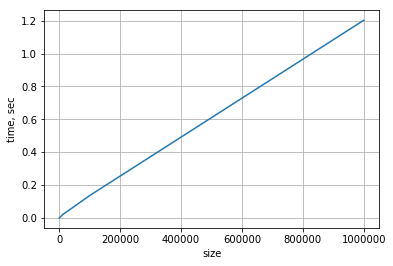

In [11]:
stats = []
for i in range(7):
    lenL = 10**i
    L = list(range(lenL))
    ts = time.time()
    random.shuffle(L)
    t  = time.time() - ts
    stats.append((lenL,t))
analyse_stats(stats)

**Fisher–Yates algorithm, custom implementation**

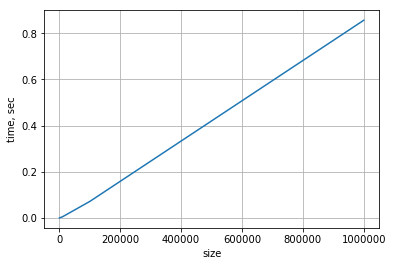

In [4]:
def customShuffle(A, s, e):
    """
    A - list to shuffle, s - start index, e - end index
    shuffled part is A[s:e]
    """
    e1 = e - 1
    delta = e-s
    for i in range(s,e):
        j = int(random.random() * delta + s)
        A[i], A[j] = A[j], A[i]
        
stats = []
for i in reversed(range(7)):
    lenL = 10**i
    L = list(range(lenL))
    ts = time.time()
    customShuffle(L, 0, lenL)
    t  = time.time() - ts
    stats.append((lenL,t))
analyse_stats(stats)

### Incertion sort

In [4]:
def sort_incertion(List, reverse = False): 
    if reverse:
        for j in range(1, len(List)):
            key = List[j]
            i = j-1
            while i>=0 and List[i]<key:
                List[i+1]=List[i]
                i = i - 1
            List[i+1] = key
    else:   
        for j in range(1, len(List)):
            key = List[j]
            i = j-1
            while i>=0 and List[i]>key:
                List[i+1]=List[i]
                i = i - 1
            List[i+1] = key

In [5]:
%%time
l = generateList(2000)
sort_incertion(l, reverse = False)
print (l[-5:])

[997, 998, 998, 999, 999]
CPU times: user 256 ms, sys: 0 ns, total: 256 ms
Wall time: 257 ms


### Merge sort

In [6]:
def merge(List, start, middle, end):
    len1 = middle - start
    len2 = end - middle
    left = List[start:middle]
    right = List[middle:end]
    i,j,k = 0,0,start
    while i < len1 and j < len2:
        if left[i] < right[j]:
                List[k] = left[i] 
                i += 1
        else:
                List[k] = right[j]
                j += 1
        k += 1
        
    if i == len1:
        while j < len2:
                List[k] = right[j]
                j += 1; k += 1
    elif j == len2 :
        while i < len1 :
                List[k] = left[i]
                i += 1; k += 1

def sort_merge(List, start, end, reverse = False): 
    if start < end-1:       
        middle = (start + end) // 2
        sort_merge(List, start, middle)
        sort_merge(List, middle, end)
        merge(List, start, middle, end)

In [7]:
%%time
l = generateList(20000)
sort_merge(l,0,len(l), reverse = False)
print (l[:5])

[0, 0, 0, 0, 0]
CPU times: user 168 ms, sys: 0 ns, total: 168 ms
Wall time: 170 ms


### Merge Sort algorithm analysis

In [8]:
def merge(List, start, middle, end):
    len1 = middle - start                    # O(1)
    len2 = end - middle                      # O(1)
    left = List[start:middle]                # O(n/2)
    right = List[middle:end]                 # O(n/2)
    i,j,k = 0,0,start                        # O(1)
    while i < len1 and j < len2:                     #
        if left[i] < right[j]:                       #
                List[k] = left[i]                    #
                i += 1                               #  O(n)
        else:                                        #  проходим по всем элементам от start to end
                List[k] = right[j]                   #  критический случай start = 0, end equals n => O(n)
                j += 1                               #
        k += 1                                       #
                                                     #
    if i == len1:                                    #
        while j < len2:                              #
                List[k] = right[j]                   #
                j += 1; k += 1                       #   
    elif j == len2 :                                 #   
        while i < len1 :                             #
                List[k] = left[i]                    
                i += 1; k += 1                       #  total: O(n)  #~2n

def sort_merge(List, start, end, reverse = False): 
    if start < end-1:                                  # O(1) 
        middle = (start + end) // 2                     # O(1)
        sort_merge(List, start, middle)                # T(n/2)
        sort_merge(List, middle, end)                  # T(n/2)
        merge(List, start, middle, end)                # O(n)
#generateList(100, minim = 0, maxim = 1000)

#so, T(n) = 2*T(n/2) + O(n); T(2) = 1
#or: T(n) = 2*T(n/2) + const*n; T(2) = 1

### Bubble sort

In [9]:
def sort_bubble(List, reverse = False):
    lenList = len(List)
    i = 0
    while i < lenList:
        j = lenList-1
        while j >= i:
            if List[j] < List[j-1]:
                List[j], List[j-1] = List[j-1], List[j]
            j -= 1
        i += 1

In [10]:
%%time
l = generateList(4000)
sort_bubble(l, reverse = False)
print (l[:5])

[0, 0, 0, 0, 1]
CPU times: user 2.54 s, sys: 0 ns, total: 2.54 s
Wall time: 2.55 s


### Max sub sequence problem

Problem:

We have stock price history. Find maximum of maney we can earn.

In [11]:
input_price = [81,82,85,83,87,84,82,85,83,84,87,87,84,82,84,83,86,87,82,82]

Let's find deltas between prices. So, now we have to find subarray with maximun od sum of elements. Sum elements of maximum subarray is maximum maney we can earn.

In [12]:
deltas = [ a - b for a,b in zip(input_price[1:], input_price[:-1]) ]

In [13]:
deltas

[1, 3, -2, 4, -3, -2, 3, -2, 1, 3, 0, -3, -2, 2, -1, 3, 1, -5, 0]

let's use **divide-and-conquer** algorithm

In [14]:
def FindMaxCrossingSubarray(A, low, mid, high):
    left_sum = 0 ; max_left = mid
    summa = 0; i = mid - 1
    while i >= low:
        summa += A[i]
        if summa > left_sum:
            left_sum = summa
            max_left = i
        i -= 1
    right_sum = 0; max_right = mid
    summa = 0; j = mid
    while j < high:
        summa += A[j]
        if summa > right_sum:
            right_sum = summa
            max_right = j
        j += 1
    return max_left, max_right, left_sum + right_sum

def FindMaximumSubarray(A,low,high):
    if high - 1 == low:
        return (low,high,A[low])    #base case: only 1 element
    else:
        mid = (low+high)//2
        left_low, left_high, left_sum = FindMaximumSubarray(A,low,mid)
        right_low,right_high, right_sum = FindMaximumSubarray(A,mid,high)
        cross_low, cross_high, cross_sum = FindMaxCrossingSubarray(A, low, mid, high)
        
        if left_sum > right_sum and left_sum > cross_sum:
            return left_low, left_high, left_sum
        elif right_sum > left_sum and right_sum > cross_sum:
            return right_low, right_high, right_sum
        else:
            return cross_low, cross_high, cross_sum

In [15]:
FindMaximumSubarray(deltas,0,len(deltas))

(0, 9, 6)

### Solve recursion equation

 good article:
 http://www.math.kth.se/math/student/courses/5B1203/F/200304/linrek.pdf
 
 merge sort:
 
 T(n) = 2*T(n/2) + 2*n
 
 T(2) = 1

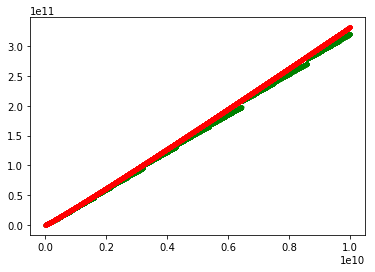

In [16]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def solve_recursion(n):
    if n <= 2:
        return 1
    else:
        n = n//2
        return 2*solve_recursion(n) + 2*n
    
x = range(1,10000000000,1000000)
y = []; y_check = [];
check_func = lambda x: x*np.log2(x)

for el in x:
    y.append(solve_recursion(el))
    y_check.append(check_func(el))

plt.plot(x,y, 'g.')
plt.plot(x,y_check, 'r.')
plt.show()

### Heap sort

In [17]:
def getParent(i):
    if i <= 0:
        return -1
    else:
        return (i-1)//2
def getLeft(i):
    return i*2+1
def getRight(i):
    return 2*(i+1)

def maxHeapify(A,i, heap_size): # for 1 thread
               # heap_size is num of elements in array
    l = getLeft(i)
    r = getRight(i)
    
    largest = i
    if l < heap_size:
        if A[l] > A[i]:
            largest = l

    if r < heap_size:
        if A[r] > A[largest]:
            largest = r

    if largest != i:
        A[i], A[largest] = A[largest], A[i]
        maxHeapify(A,largest,heap_size)
        
def buildMaxHeap(A):
    lenA = len(A)
    for i in range(0,len(A)//2)[::-1]:
        maxHeapify(A,i,lenA)

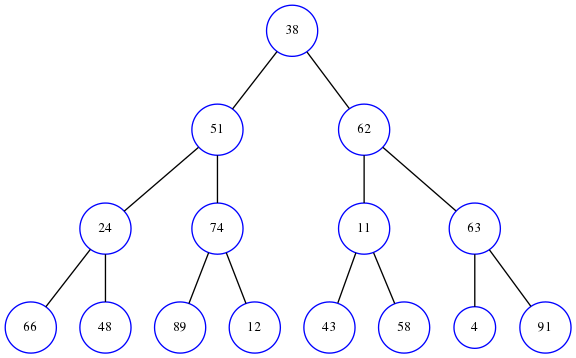

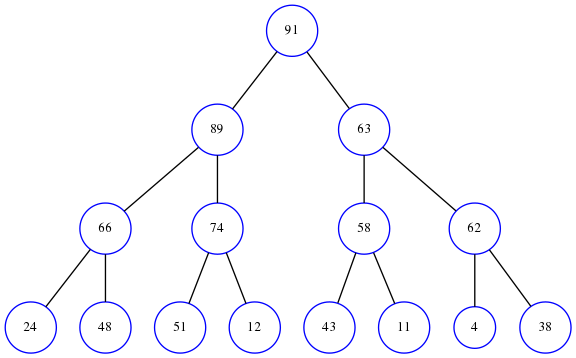

In [18]:
A = generateList(15, maxim = 100)
display_heap(A)
buildMaxHeap(A)
display_heap(A)

In [19]:
A = generateList(15, maxim = 100)
def heapSort(A):
    buildMaxHeap(A)
    heapSize = len(A)
    for i in range(len(A)-1, 0, -1):
        A[0],A[i] = A[i], A[0]
        heapSize = heapSize - 1
        maxHeapify(A,0,heapSize)
heapSort(A)
print (A)

[2, 11, 16, 20, 24, 54, 61, 71, 87, 88, 89, 90, 94, 95, 99]


### Quicksort

In [20]:
def partition(A,p,r):
    """
    reorder the array so that all elements with values less than the pivot 
    come before the pivot, while all elements with values greater than 
    the pivot come after it (equal values can go either way); 
    function returns pivot index
    """
    x = A[r]
    i = p - 1
    #all elements the fewer the last element 
    # we send to first positions of the list
    for j in range(p,r):
        if A[j] <= x:
            i += 1
            A[i], A[j] = A[j], A[i]

    A[i+1], A[r] = A[r], A[i+1]
    return i+1
    
def quicksort(A,p,r):
    if p<r:
        q = partition(A,p,r)
        quicksort(A,p,q-1)
        quicksort(A,q+1,r)

In [21]:
A = generateList(15, maxim = 1000)
print (A)
quicksort(A, 0,len(A)-1)
print (A)
print (isSorted(A))

[90, 247, 828, 635, 878, 55, 868, 236, 490, 455, 773, 599, 315, 988, 729]
[55, 90, 236, 247, 315, 455, 490, 599, 635, 729, 773, 828, 868, 878, 988]
True


### Randomized Quicksort

In [22]:
def rand_partition(A,p,r):
    i = random.randint(p,r)
    A[r], A[i] = A[i], A[r]
    return partition(A,p,r)

def rand_quicksort(A,p,r):
    """
    the main difference from quicksort algo is the pivot element 
    is random selected (not the last one)
    """  
    if p < r:
        q = rand_partition(A,p,r)
        rand_quicksort(A,p,q-1)
        rand_quicksort(A,q+1,r)

In [23]:
A = generateList(15, maxim = 1000)
print (A)
rand_quicksort(A, 0,len(A)-1)
print (A)
print (isSorted(A))

[714, 239, 943, 275, 230, 82, 593, 647, 969, 236, 315, 890, 637, 128, 539]
[82, 128, 230, 236, 239, 275, 315, 539, 593, 637, 647, 714, 890, 943, 969]
True


### Counting sort
**(for positive integers)**

In [24]:
def counting_sort(A):
    lenA = len(A)
    k = max(A)
    C = [0]*(k+1)  #auxiliary array, (k+1) possible valies
    
    for j in range(lenA):
        C[A[j]] = C[A[j]] + 1
    #C[i] contains the number of elements equal to i

    for k in range(1,k+1):
        C[k] = C[k]+C[k-1]
    #now C[i] contains number of elements less then or equal to i
    
    B = [0]*lenA  #output array
    
    for j in range(lenA)[::-1]:
        B[C[A[j]] - 1] = A[j]
        C[A[j]] = C[A[j]] - 1
        
    A[:] = B

In [25]:
def counting_sort_DenisWay(A):
    lenA = len(A)
    k = max(A)
    C = [0]*(k+1)  #auxiliary array, (k+1) possible valies
    
    #C[i] will contain the number of elements equal to i:
    j = 0
    while j < lenA:
        C[A[j]] = C[A[j]] + 1
        j += 1

    #reveal C:
    j = 0
    indC = 0
    while indC < k + 1:
        c = 0
        while c < C[indC]:
            A[j] = indC
            c += 1
            j += 1
        indC += 1

In [26]:
%%time
A = generateList(10**6, maxim = 10**6)
print (A[:10])
counting_sort(A)
print (A[:10])
isSorted(A)

[49556, 371781, 566865, 713236, 33970, 427132, 61446, 601639, 568020, 918585]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
CPU times: user 3.4 s, sys: 60 ms, total: 3.46 s
Wall time: 3.46 s


In [27]:
%%time
A = generateList(10**6, maxim = 10**6)
print (A[:10])
counting_sort_DenisWay(A)
print (A[:10])
isSorted(A)

[276376, 930947, 441428, 814931, 96810, 830552, 273588, 743687, 503001, 751253]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
CPU times: user 2.83 s, sys: 16 ms, total: 2.85 s
Wall time: 2.85 s


### Bucket sort
**(for values in range [0,1))**

In [28]:
A = np.linspace(0,1.0,num=19, endpoint = False); 
A = [round(x,2) for x in A]
np.random.shuffle(A)

In [29]:
def bucket_sort(A):
    """
    1. putting each A[i] element to corresponded bucket
    2. sort each non-empty bucket
    3. concentrate the elements in buckets
    """
    B = [[] for _ in range(10)]
    for i in range(len(A)):
        index = int(10*A[i])
        B[index].append(A[i])
        
    #sort each bucket and 
    for i in range(10):
        sort_incertion(B[i])
            
    #concentrate the lists B[i] together in order
    k = 0
    for i in range(10):
        lenBi = len(B[i])
        A[k:k+lenBi] = B[i]
        k = k + lenBi

In [30]:
A = np.linspace(0,1.0,num=20, endpoint = False);
#A = [round(x,2) for x in A]
print (A[:10])
np.random.shuffle(A)
print (A[:10])
bucket_sort(A)
print (A[:10])

[ 0.    0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45]
[ 0.4   0.1   0.2   0.35  0.05  0.65  0.8   0.7   0.45  0.9 ]
[ 0.    0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45]


### Minimum and Maximum

In [31]:
def minimum(A):  #n operations, O(n)
    lenA = len(A)
    m = A[0]
    for i in range(1,lenA):
        if A[i] < m:
            m = A[i]
    return m

def maximun(A):  #n operations, O(n)
    lenA = len(A)
    m = A[0]
    for i in range(1,lenA):
        if A[i] > m:
            m = A[i]
    return m

def both_max_min(A):   # 1.5n operations, O(n)
    mini = A[0]
    maxi = A[0]
    lenA = len(A)
    i = 1
    while i+1 < lenA:
        if A[i+1]>=A[i]:
            if A[i+1] > maxi:
                maxi = A[i+1]
            if A[i] < mini:
                mini = A[i]
        else:
            if A[i] > maxi:
                maxi = A[i]
            if A[i+1] < mini:
                mini = A[i+1]
        i += 2
    if i == lenA-1:
        if A[i]> maxi:
            maxi = A[i]
        elif A[i] < mini:
            mini = A[i]
    return mini, maxi

In [32]:
A = generateList(16, maxim = 1000)
print (A)
print ("the minimum is {}".format(minimum(A)))
print ("the maximum is {}".format(maximun(A)))
print ("both are: {} and {}".format(*both_max_min(A)))

[11, 225, 345, 699, 249, 796, 121, 131, 582, 355, 950, 459, 223, 567, 471, 813]
the minimum is 11
the maximum is 950
both are: 11 and 950


### k*th* minimum element

In [33]:
def partition(A,p,r):
    """
    reorder the array so that all elements with values less than the pivot 
    come before the pivot, while all elements with values greater than 
    the pivot come after it (equal values can go either way); 
    function returns pivot index
    """
    x = A[r]
    i = p - 1
    #all elements the fewer the last element 
    # we send to first positions of the list
    for j in range(p,r):
        if A[j] <= x:
            i += 1
            A[i], A[j] = A[j], A[i]
    A[i+1], A[r] = A[r], A[i+1]
    return i+1

def rand_partition(A,p,r):
    i = random.randint(p,r)
    A[r], A[i] = A[i], A[r]
    return partition(A,p,r)

def randomized_select(A,p,r,i):
    """
    returns the i_th smallest element of the array A
    """ 
    if p == r:
        #slice of the list consists of only 1 element
        return A[p]
    #split the A[p,r] by delimiter q such elements in A[p:q] less A[q]
    #and A[q+1:r] is more or equal A[q]:
    q = rand_partition(A,p,r) 
    #num of elements in the left list of A[p:q]:
    k = q - p + 1  
    if i == k:
        #bingo!
        return A[q]
    elif i < k: 
        #the necessary element on the left side of partition
        return randomized_select(A,p,q-1,i)
    else:
        #the necessary element on the right side of partition
        return randomized_select(A,q+1,r,i-k)

In [34]:
A = generateList(16, maxim = 1000)
k = 10
Kth_min = randomized_select(A, 0, len(A)-1, k)
print (Kth_min)
quicksort(A, 0, len(A)-1)
print (k, A[k-1])

404
10 404


### Rod cutting problem

Problem:

Given a rod of length $n$ inches and a table of prices $p_{i}$ for $i$ = 1,2,...,n:

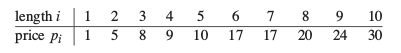

In [35]:
Image(filename="pics/rod_cutting_problem_1.png", width=None, height=None)

determine the maximum revenue r n obtainable by cutting up the rod and selling the pieces. 

The 8 possible ways of cutting up a rod of length 4:

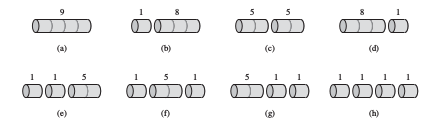

In [36]:
Image(filename="pics/rod_cutting_problem_2.png", width=None, height=None)

#### a) divide and conquer method

In [37]:
def cutRod(prices, n):
    if n==0:
        return 0
    q = prices[0]*n #price with split on all possible parts
    for i in range(0, n):
        q = max(q, prices[i]+cutRod(prices, n-i-1))
    return q

In [38]:
num = 2
lengths = range(1, num+1)
prices = generateList(num, minim = -20, maxim = 20)
print (zip_(lengths, prices))
print (cutRod(prices, len(prices)))

[(1, 12), (2, -12)]
24


In [39]:
TestCutRod(num_tests = 10000, func = cutRod).run()

10000 tests passed out of 10000 in 0.1472 seconds


**running time analysis**

Let $T(n)$ denote total number of calls to $cutRod$ function. The count includes the initial call at its root.Thus

$$T(0)=1$$
$$T(n) = 1 + \sum_{j=0}^{n-1} T(j)$$

Let's solve the recursion equation

$T_n = T_{n-1}+T_{n-2}+...+T_{0}+1$

$T_{n-1} = T_{n-2}+T_{n-3}+...+T_{0}+1$

Therefore:

$T_n = T_{n-1}+T_{n-1} = 2T_{n-1}$

characteristic eqution:

$P(x)=x^1-2x^0=0 => x = 2$

General solution:
$T_n = A2^n$

Based on condition $T(0)=1$:

$1=A2^0 => A=1$

Therefore:
$$T(n)=2^n$$

let's check the results:

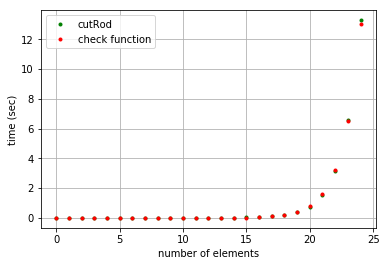

In [40]:
stats = []
for num in tqdm_notebook(range(0,25,1)):
    prices = generateList(num, minim = -2000, maxim = 2000)
    start_time = time.time()
    _ = cutRod(prices, len(prices))
    t = time.time() - start_time
    stats.append((num, t))       
stats = np.array(stats)

check_func = lambda x: 2**x
corrector = np.mean(check_func(stats[-3:,0])/stats[-3:,1])

plt.plot(stats[:,0],stats[:,1], 'g.', label = 'cutRod')
plt.plot(stats[:,0],check_func(stats[:,0])/corrector, 'r.', label = 'check function')
plt.grid(True)
plt.ylabel('time (sec)')
plt.xlabel('number of elements')
plt.legend()
plt.show()

#### b) dimanic programming method

* **top-down with memoization**

In [41]:
def memoizedCutRodAux(p, n, r):
    #check, whether the desired value is already known
    if r[n] != None:
        return r[n]
    elif n == 0:
        q = 0
    else:
        q = None
        for i in range(n):
            q = max_(q, p[i] + memoizedCutRodAux(p, n-i-1, r))
    r[n] = q
    return q

#wrapper
def memoizedCutRod(p, n):
    r = [None]*(n + 1)
    return memoizedCutRodAux(p, n, r)

num = 2
prices = generateList(num, minim=-200, maxim=200)
print (prices)
print (memoizedCutRod(prices, num))
TestCutRod(num_tests=10000, func=memoizedCutRod).run()
print(memoizedCutRodAux(prices, num, [None]*(num+1))) #call without wrapper

[-149, -183]
-183
10000 tests passed out of 10000 in 0.2382 seconds
-183


* **bottom-up method**

In [42]:
def bottomUpCutRod(p, n):
    #create r in which we will save the results of the small subproblems
    #declarer[0] = 0 is case length of rod equals zero
    r = [0]
    for j in range(1, n+1):
        q = None
        for i in range(0, j):
            q = max_(q, p[i] + r[j-i-1])
        #save the solution of j size subproblem 
        r.append(q)
    return r[n]

num = 450
prices = generateList(num, minim=-200, maxim=200)
print(bottomUpCutRod(prices,num))
TestCutRod(num_tests=10000, func=bottomUpCutRod).run()

13680
10000 tests passed out of 10000 in 0.2214 seconds


**running time analysis of top-down with memoization and bottom-up methods**

$running\ time\ is\ \Theta(n^2)$ due to doubly-nested loop structures of both methods

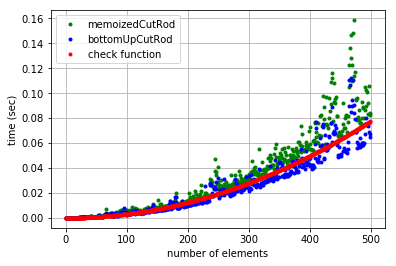

In [43]:
stats = []
for num in tqdm_notebook(range(0,500,1)):
    prices = generateList(num, minim = -2000, maxim = 2000)
    start_time = time.time()
    _ = memoizedCutRod(prices, len(prices))
    t1 = time.time() - start_time
    start_time = time.time()
    _ = bottomUpCutRod(prices, len(prices))
    t2 = time.time() - start_time
    stats.append((num, t1, t2))       
stats = np.array(stats)

check_func = lambda x: x**2
corrector = 0.5*np.mean(check_func(stats[-20:,0])/stats[-20:,1]) + \
            0.5*np.mean(check_func(stats[-20:,0])/stats[-20:,2])

plt.plot(stats[:,0],stats[:,1], 'g.', label='memoizedCutRod')
plt.plot(stats[:,0],stats[:,2], 'b.', label='bottomUpCutRod')
plt.plot(stats[:,0],check_func(stats[:,0])/corrector, 'r.', label = 'check function')
plt.grid(True)
plt.ylabel('time (sec)')
plt.xlabel('number of elements')
plt.legend()
plt.show()

### Matrix chain multiplication 
#### (application of dinamic programming example)

how to select order of matrixes multiplication that minimizes the number of scalar multiplications

$A_1 \cdot A_2 \cdot A_3 \cdot A_4$

examples of possible decisions:

- $(A_1 \cdot (A_2 \cdot (A_3 \cdot A_4)))$ 

- $((A_1 \cdot A_2) \cdot (A_3 \cdot A_4))$


In [207]:
class Matrix(object):
    def check_matrix(self):
        prev_len = len(self.list[0])
        for item in self.list:
            if len(item) != prev_len:
                return False
            prev_len = len(item)       
        return True
    
    def __init__(self,l):
        self.list = l
        self.rows = len(l)
        self.columns = len(l[0])
        assert self.check_matrix()==True, "the matrix is wrong"

        
def generate_matrix(num_rows, num_columns, minim=0, maxim=10):
    matrix = []
    for _ in range(num_rows):
        matrix.append(generateList(num_columns, minim=minim, maxim=maxim))
    return matrix  
    
        
def generate_seq(*args):
    seq = []
    for el in args:
        rows = len(el)
        columns = len(el[0])
        seq.append([rows,columns])
    return seq


def generate_short_seq(*args):
    seq = generate_seq(*args)
    
    short_seq = []
    short_seq.append(seq[0][0])
    for el in seq:
        short_seq.append(el[1])
    return short_seq


def dot_product(A,B):
    A_columns = len(A[0])
    A_rows = len(A)
    B_columns = len(B[0])
    B_rows = len(B)
    
    assert A_columns == B_rows, "incompatible dimensions"
    
    #create empty list
    C = [[None]*B_columns for _ in range(A_rows)]
    #every line of A multiply on every column of B
    for i in range(A_rows):
        for j in range(B_columns):
            C[i][j] = 0
            for k in range(A_columns):
                C[i][j] += A[i][k]*B[k][j]    
    return C

In [208]:
A = generate_matrix(6,7, minim=0, maxim=10)
B = generate_matrix(7,3, minim=0, maxim=10)
print_(dot_product(A,B))

293   50  172
201   91  195
200  106  179
327   79  203
230   94  204
203  102  166


complexity of **dot_product** is $A_{columns} \cdot B_{columns} \cdot A_{rows}$ ~ $n^3$

Applying dynamic programming
We shall use the dynamic-programming method to determine how to optimally
parenthesize a matrix chain. In so doing, we shall follow the four-step sequence
that we stated at the beginning of this chapter:
1. Characterize the structure of an optimal solution.
2. Recursively define the value of an optimal solution.
3. Compute the value of an optimal solution.15.2 Matrix-chain multiplication
4. Construct an optimal solution from computed information.

$m[i,j]$ is cost of calculation of matrixes $A_i \cdot A_{i+1} \cdot \cdot \cdot A_j$

size of $A_j$ is $p_{i-1} \times p_i$

$m[i,j] = m[i,k] + m[k+1,j] + p_{i-1} p_k p_j$

Thus, our recursive defenition for the minimum cost of paranthesizing the product $A_i \cdot A_{i+1} \cdot \cdot \cdot A_j$ becomes:


$m[i,j] = 0,\ if\ i=j,\ or$

$m[i,j] = \min_{i \leq k<j}\{m[i,k] + m[k+1,j] + p_{i-1} p_k p_j\}\ if\ i<j$

**bottom-up approach implementation**

sequence $p = p_0, p_1, p_2, \dots p_n$ contains all necessery information about matrixes

let *m* is auxiliary matrix $n \times n$ for storing the $m[i,j]$ costs and
matrix $s[1 \dots n-1, 2 \dots n]$ that records witch index of *k* achived optimal solution in computing $m[i,j]$

In [209]:
#generate matrixes pool
matrix_pool = []
num_rows = random.randint(3,10)
for _ in range(6):
    num_columns = random.randint(3,10)
    matrix = generate_matrix(num_rows, num_columns, minim=0, maxim=10)
    matrix_pool.append(matrix)
    num_rows = num_columns

seq = generate_seq(*matrix_pool)
p = generate_short_seq(*matrix_pool)
print(seq)
print(p)

[[8, 5], [5, 10], [10, 7], [7, 3], [3, 3], [3, 5]]
[8, 5, 10, 7, 3, 3, 5]


In [9]:
p = list(map(int, "30 35 15 5 10 20 25".split(' ')))

def matrix_chain_order(p):
    # number of matrixes:
    n = len(p) - 1
    m = [[0]*n for _ in range(n)]
    s = [[0]*n for _ in range(n)]
    
    for l in range(2, len(p)): #l is the chain length
        for i in range(n-l+1):
            j = i + l - 1
            m[i][j] = math.inf
            for k in range(i, j):
                q = m[i][k] + m[k+1][j] + p[i-1]*p[k]*p[j]
                # debug:
                #print("l={}; i={}; j={}; k={}; q={}; ".format(l,i,j,k,q))
                if q < m[i][j]:
                    m[i][j] = q
                    s[i][j] = k  #the best split between i and j
    return m, s

m,s = matrix_chain_order(p)

In [10]:
def print_optimal_parents(s,i,j):
    if i == j:
        print("A{}".format(i+1), end = "")
    else:
        print("(", end = "")
        print_optimal_parents(s,i,s[i][j])
        print_optimal_parents(s,s[i][j]+1,j)
        print(")", end = "")

In [13]:
print_optimal_parents(s,0,len(s[0])-1)

((A1(A2(A3A4)))(A5A6))

### Longest common subsequence

The problem is to determine how "similar" the two sequences

#### brute-force approach (for testing)
enumerate all subsequences of $S_1$ and check each subsequence to see whether it is also a subsequence of $S_2$

In [11]:
def random_string(N, elements = None):
    if elements == None:
        elements = string.ascii_uppercase
    return ''.join(random.choice(elements) for _ in range(N))

def subseq_in_S2(subseq, S2):
    S2 = list(S2)
    j = 0
    max_j = len(S2) - 1
    for element in subseq:
        if j > max_j:
            return False
        while element != S2[j]:
            j += 1
            if j > max_j:
                return False
        j += 1
    return True

def brute_force_algo(S1,S2):
    longest_len = 0
    longest_subs = ""
    for i, _ in enumerate(S1):
        i += 1
        for subseq in itertools.combinations(S1, i):
            subseq = "".join(subseq)
            if subseq_in_S2(subseq, S2):
                longest_len = i
                longest_subs = subseq
    return longest_len, longest_subs

In [12]:
S1 = random_string(10, elements=['A','B','C','D','E','F'])
S2 = random_string(10, elements=['A','B','C','D','E','F'])
print("S1 = {}; S2 = {}".format(S1,S2))
brute_force_algo(S1, S2)

S1 = CEFEFBABFA; S2 = FFCBFCDBEB


(4, 'FFBF')

#### dinamic programming method

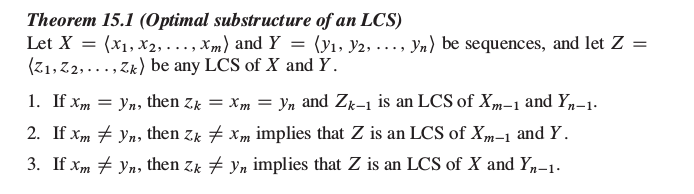

In [13]:
Image(filename="pics/longest_common_sequence.png", width=None, height=None)

In [14]:
def LCS_length(X, Y):
    lenX = len(X)
    lenY = len(Y)
    
    #axylary matrixes:
    b = [[0]*(lenY) for _ in range(lenX)]
    c = [[0]*(lenY+1) for _ in range(lenX+1)] 
    
    for i in range(1,lenX+1):
        for j in range(1,lenY+1):
            if X[i-1]==Y[j-1]:
                c[i][j] = c[i-1][j-1] + 1
                b[i-1][j-1] = u'\u21F1' #'diag'
            elif c[i-1][j] >= c[i][j-1]:
                c[i][j] = c[i-1][j]
                b[i-1][j-1] = u'\u2191' #'up'
            else:
                c[i][j] = c[i][j-1]
                b[i-1][j-1] = u'\u27F5' #'left'
    return c, b

In [15]:
S1 = random_string(15, elements=['A','B','C','D','E'])
S2 = random_string(15, elements=['A','B','C','D','E'])
print("S1 = {}; S2 = {}".format(S1,S2))
brute_force_algo(S1, S2)

S1 = DBCCDDBDCDBCBBD; S2 = CCADDDCADBBCBBC


(11, 'CCDDDCDBCBB')

In [16]:
c, b = LCS_length(S1,S2)

In [17]:
print_(b)

↑  ↑  ↑  ⇱  ⇱  ⇱  ⟵  ⟵  ⇱  ⟵  ⟵  ⟵  ⟵  ⟵  ⟵
↑  ↑  ↑  ↑  ↑  ↑  ↑  ↑  ↑  ⇱  ⇱  ⟵  ⇱  ⇱  ⟵
⇱  ⇱  ⟵  ↑  ↑  ↑  ⇱  ⟵  ⟵  ↑  ↑  ⇱  ⟵  ⟵  ⇱
⇱  ⇱  ⟵  ⟵  ⟵  ⟵  ⇱  ↑  ↑  ↑  ↑  ⇱  ↑  ↑  ⇱
↑  ↑  ↑  ⇱  ⇱  ⇱  ⟵  ⟵  ⇱  ⟵  ⟵  ↑  ↑  ↑  ↑
↑  ↑  ↑  ⇱  ⇱  ⇱  ⟵  ⟵  ⇱  ⟵  ⟵  ⟵  ⟵  ⟵  ↑
↑  ↑  ↑  ↑  ↑  ↑  ↑  ↑  ↑  ⇱  ⇱  ⟵  ⇱  ⇱  ⟵
↑  ↑  ↑  ⇱  ⇱  ⇱  ⟵  ⟵  ⇱  ↑  ↑  ↑  ↑  ↑  ↑
⇱  ⇱  ↑  ↑  ↑  ↑  ⇱  ⟵  ⟵  ⟵  ⟵  ⇱  ⟵  ⟵  ⇱
↑  ↑  ↑  ⇱  ⇱  ⇱  ↑  ↑  ⇱  ⟵  ⟵  ⟵  ⟵  ⟵  ⟵
↑  ↑  ↑  ↑  ↑  ↑  ↑  ↑  ↑  ⇱  ⇱  ⟵  ⇱  ⇱  ⟵
⇱  ⇱  ↑  ↑  ↑  ↑  ⇱  ↑  ↑  ↑  ↑  ⇱  ⟵  ⟵  ⇱
↑  ↑  ↑  ↑  ↑  ↑  ↑  ↑  ↑  ⇱  ⇱  ↑  ⇱  ⇱  ⟵
↑  ↑  ↑  ↑  ↑  ↑  ↑  ↑  ↑  ⇱  ⇱  ↑  ⇱  ⇱  ⟵
↑  ↑  ↑  ⇱  ⇱  ⇱  ↑  ↑  ⇱  ↑  ↑  ↑  ↑  ↑  ↑


In [18]:
print_(c)

0  0  0  0  0  0  0  0  0  0  0  0  0   0   0   0
0  0  0  0  1  1  1  1  1  1  1  1  1   1   1   1
0  0  0  0  1  1  1  1  1  1  2  2  2   2   2   2
0  1  1  1  1  1  1  2  2  2  2  2  3   3   3   3
0  1  2  2  2  2  2  2  2  2  2  2  3   3   3   4
0  1  2  2  3  3  3  3  3  3  3  3  3   3   3   4
0  1  2  2  3  4  4  4  4  4  4  4  4   4   4   4
0  1  2  2  3  4  4  4  4  4  5  5  5   5   5   5
0  1  2  2  3  4  5  5  5  5  5  5  5   5   5   5
0  1  2  2  3  4  5  6  6  6  6  6  6   6   6   6
0  1  2  2  3  4  5  6  6  7  7  7  7   7   7   7
0  1  2  2  3  4  5  6  6  7  8  8  8   8   8   8
0  1  2  2  3  4  5  6  6  7  8  8  9   9   9   9
0  1  2  2  3  4  5  6  6  7  8  9  9  10  10  10
0  1  2  2  3  4  5  6  6  7  8  9  9  10  11  11
0  1  2  2  3  4  5  6  6  7  8  9  9  10  11  11


In [55]:
def print_LCS(b, X, i, j, A):
    if i==-1 or j==-1:
        return None
    if b[i][j] == u'\u21F1': #diag
        print_LCS(b, X, i-1, j-1, A)
        A.append(X[i])
    elif b[i][j] == u'\u2191': #up
        print_LCS(b, X, i-1, j, A)
    else:
        print_LCS(b, X, i, j-1, A)

def get_result(b, S1):
    A = []
    print_LCS(b, S1, len(S1)-1, len(S2)-1, A)
    return "".join(A)
        
LCS = get_result(b, S1)
print(f"lenght od LCS = {len(LCS)}")
print(f"LCS: {LCS}")

lenght od LCS = 11
LCS: CCDDDCDBCBB


### Optimal binary search trees

What we need to know as an **optimal binary search tree**. Formally, we are given a sequence $K = \langle k_1,k_2,...,k_n \rangle$ of $n$ distinct keys in sorted order (so that $k_1 < k_2 <...<k_n$), and we wish to build a binary search tree from these keys. For each key $k_i$, we have a probability $p_i$ that a search will be for $k_i$. Some searches may be for values not in $K$, and so we also have $n+1$ 'dummy keys'

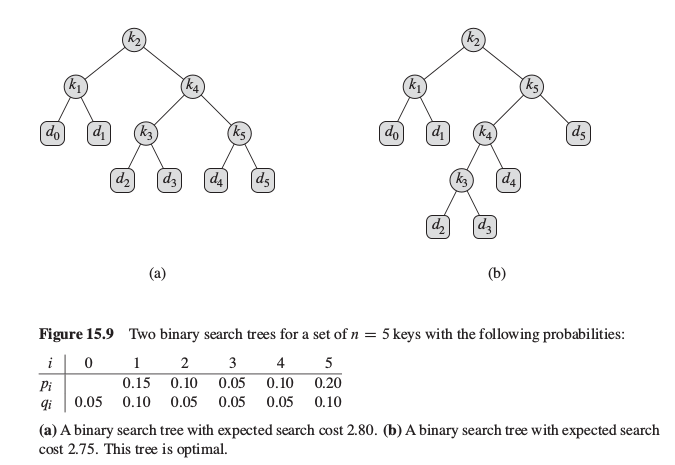

In [58]:
Image(filename="pics/optimal_binary_search_tree.png", width=None, height=None)

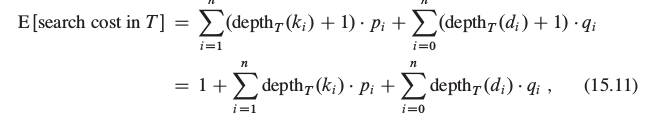

In [59]:
Image(filename="pics/optimal_binary_search_tree_2.png", width=None, height=None)

In [75]:
def optimal_BST(p, q, n):
    e = [[0]*(n+1) for _ in range(n+1)]
    w = [[0]*(n+1) for _ in range(n+1)]
    root = [[0]*n for _ in range(n)]
    
    for i in range(n+1):
        e[i][i] = q[i]
        w[i][i] = q[i]
    for l in range(1,n+1):
        for i in range(1,n-l+1+1):
            j = i+l-1
            e[i-1][j] = 999999999999999999999
            w[i-1][j] = w[i-1][j-1] + p[j-1] + q[j]
            for r in range(i,j+1):
                t = e[i-1][r-1] + e[r+1-1][j] + w[i-1][j]
                if t < e[i-1][j]:
                    e[i-1][j] = t
                    root[i-1][j-1] = r
    return e, root

In [76]:
p = [0.15, 0.10, 0.05, 0.1, 0.2]
q = [0.05, 0.1, 0.05, 0.05, 0.05, 0.10]
e, root = optimal_BST(p,q,len(p))

In [194]:
print_(e, num_digits_after_dot=2)

0.05  0.45  0.90  1.25  1.75  2.75
   0  0.10  0.40  0.70  1.20  2.00
   0     0  0.05  0.25  0.60  1.30
   0     0     0  0.05  0.30  0.90
   0     0     0     0  0.05  0.50
   0     0     0     0     0  0.10


In [195]:
print_(root)

1  1  2  2  2
0  2  2  2  4
0  0  3  4  5
0  0  0  4  5
0  0  0  0  5


In [318]:
def print_optimal_BST(root, start, end, parent = None, side = None):
    r = root[start][end]
    r_ind = r - 1
    
    if parent is None:
        print ("k_{} is the root".format(r))
    else:
        print ("k_{} is the {} child of k_{}".format(r, side, parent))
           
    if start == r_ind:
        print ("d_{} is the left child of k_{}".format(r-1, r-0))
    else:
        print_optimal_BST(root, start, r_ind-1, parent = r, side = "left")
        
    if end == r_ind:
        print ("d_{} is the right child of k_{}".format(r, r))
    else:
        print_optimal_BST(root, r_ind+1, end, parent = r, side = "right")

In [319]:
find_root_and_childs(root, 0, len(root)-1)

k_2 is the root
k_1 is the left child of k_2
d_0 is the left child of k_1
d_1 is the right child of k_1
k_5 is the right child of k_2
k_4 is the left child of k_5
k_3 is the left child of k_4
d_2 is the left child of k_3
d_3 is the right child of k_3
d_4 is the right child of k_4
d_5 is the right child of k_5


## Greedy Algorithms

### Activity selection problem

The problem of scheduling several competing activities that require exlusive use of a common resources with a goal of selecting a maximum-size set of mutually campatible activities.

In [9]:
# generate processes
# the first number is start time of a process, the second one is finish time
num_processes = 10
s = generateList(num_processes, minim=0, maxim=23)
f = generateList(num_processes, minim=0, maxim=23)
pairs = [(a,b) if a < b else (b,a) for a,b in zip(s,f)]
pairs = [(a,a+1) if a==b else (a,b) for (a,b) in pairs]
pairs.sort(key = lambda x: (x[1],x[0]))
print_(pairs)

 2   5
 6   7
 1   9
 3  10
 6  13
 7  14
 3  16
 1  17
 0  20
19  20


#### brute-force approach (for testing)

In [10]:
def analyse_seq(seq):
    for a,b in zip(seq[:-1], seq[1:]):
        if a[1] > b[0]:
            return 0
    return len(seq)

def brute_forse_method(pairs):
    """
    iterate through all possible combinations
    return
     - max number of activities
     - one possible subsequence
    """
    if not pairs:
        return 0, ()
    result, best_seq = 1, pairs[0]
    for seq_length in range(2,len(pairs)+1):
        for comb in itertools.combinations(pairs, seq_length):
            num_activities = analyse_seq(comb)
            if num_activities > result:
                best_seq = comb
                result = num_activities
    return result, best_seq

brute_forse_method(pairs)

(4, ((2, 5), (6, 7), (7, 14), (19, 20)))

**dynamic approach**

Let us denote by $S_{ij}$ the set of activities that start after activity $a_i$ finishes and that finish before activity $a_j$ starts.
And let $c[i,j]$ is size of the optimal solution of the set $S_{ij}$, then:

\begin{equation}
  c[i,j] =
  \begin{cases}
    0, & \text{if}\ S_{ij}=\emptyset \\
    max\{c[i,k] + c[k,j] + 1\},\ i<k<j, & \text{if}\ S_{ij}\neq\emptyset
  \end{cases}
\end{equation}

In [11]:
def is_empty_set(pairs):
    start = pairs[0]
    end = pairs[-1]
    for pair in pairs[1:-1]:
        if pair[0] >= start[1] and pair[1] <= end[0]:
            return False
    return True

print(is_empty_set([(1,2),(4,7),(8,10)]))
print(is_empty_set([(1,4),(2,7),(8,10)]))

False
True


In [12]:
def dinamic_method (pairs):
    
    #add minimum and maximum
    low_bound = min(a for a,b in pairs)
    high_bound = max(b for a,b in pairs)
    
    pairs = [(low_bound-20,low_bound-10)] + pairs + \
            [(high_bound+10,high_bound+20)]
    #print (pairs)
    
    n = len(pairs)
    c = [["NA"]*(n) for _ in range(n+1)]
    for i in range(n+1):
        for j in range(n):
            if i >= j:
                c[i][j] = 0  
    
    for step in range(1, n+1):
        #print(f'step = {step}')
        for i in range(n+1):
            j = i + step
            if j >= n:
                continue
            c[i][j] = 0
            #print (f"c[{i}][{j}] = {c[i][j]}")
            if not is_empty_set(pairs[i:j+1]):
                for k in range(i+1,j):
                    #check, is A_k in S_ij
                    if (pairs[k][0] < pairs[i][1] or 
                       pairs[k][1] > pairs[j][0]):
                        continue
                    c[i][j] = max(c[i][j], c[i][k]+c[k][j]+1)
                    #print (f"k = {k}, c[{i}][{j}] = {c[i][j]}")
    return c[0][-1]

In [13]:
pairs = [(1, 2), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12)]
dinamic_method(pairs)

6

**greedy approach**

In [149]:
def recursive_activity_selector(pairs, s,f,i,n, results):
    m = i+1
    while m <= n and s[m] < f[i]:  #search the first process in S_{i,n+1}:
        m = m + 1
    if m <= n:
        results.append(pairs[m])
        return recursive_activity_selector(pairs, s,f,m,n,results=results)
    else:
        return results
    
def greedy_method(pairs):
    """preprocessing wrapper"""
    low_bound = min(a for a,b in pairs)
    high_bound = max(b for a,b in pairs)
    pairs = [(low_bound-20,low_bound-10)] + pairs + [(high_bound+10,high_bound+20)]
    
    s = [a for a,b in pairs]
    f = [b for a,b in pairs]
    return recursive_activity_selector(pairs, s,f,0,len(pairs)-2, [])

In [150]:
pairs = [(1, 3), (2, 4), (5, 6), (7, 8), (9, 10), (11, 12)]
greedy_method(pairs)

[(1, 3), (5, 6), (7, 8), (9, 10), (11, 12)]

**convert recursive algorithm to an iterative algorithm**

In [157]:
def greedy_activity_selector(pairs):
    #preprocessing
    low_bound = min(a for a,b in pairs)
    high_bound = max(b for a,b in pairs)
    pairs = [(low_bound-20,low_bound-10)] + pairs + [(high_bound+10,high_bound+20)]
    s = [a for a,b in pairs]
    f = [b for a,b in pairs]
    n = len(pairs)
    A = []
    i = 0
    
    for m in range(1,n-1):
        if s[m] >= f[i]:
            A.append(pairs[m])
            i = m
    return A

In [158]:
pairs = [(1, 3), (2, 4), (5, 6), (7, 8), (9, 10), (11, 12)]
greedy_activity_selector(pairs)

[(1, 3), (5, 6), (7, 8), (9, 10), (11, 12)]

**check if we get the same result using every approatch**

In [160]:
# for testing, compare dimanic and brute-forse approatches
for _ in tqdm_notebook(range(100)):
    # generate processes
    num_processes = 15
    s = generateList(num_processes, minim=0, maxim=23)
    f = generateList(num_processes, minim=0, maxim=23)
    pairs = [(a, b) if a < b else (b,a) for a,b in zip(s,f)]
    pairs = [(a, a+1) if a==b else (a,b) for (a,b) in pairs]
    pairs.sort(key = lambda x: (x[1],x[0]))
    
    n1, _ = brute_forse_method(pairs)
    n2 = dinamic_method(pairs)
    n3 = len(greedy_method(pairs))
    n4 = len(greedy_activity_selector(pairs))
    if n1 == n2 == n3 == n4:
        pass
    else:
        print (f"ERROR, n1 = {n1}; n2 = {n2}; n3 = {n3}; pairs = {pairs}")

**compare the approatches**

In [161]:
stats = []
for num_processes in tqdm_notebook(range(1,300)):
    s = generateList(num_processes, minim=0, maxim=23)
    f = generateList(num_processes, minim=0, maxim=23)
    pairs = [(a, b) if a < b else (b,a) for a,b in zip(s,f)]
    pairs = [(a, a+1) if a==b else (a,b) for (a,b) in pairs]
    pairs.sort(key = lambda x: (x[1],x[0]))
    
    if num_processes < 20:
        ts = time.time()
        _,_ = brute_forse_method(pairs)
        t1 = time.time() - ts
    else:
        t1 = 0
    
    ts = time.time()
    _ = dinamic_method(pairs)
    t2 = time.time() - ts
    
    ts = time.time()
    _ = greedy_method(pairs)
    t3 = time.time() - ts
    
    ts = time.time()
    _ = greedy_activity_selector(pairs)
    t4 = time.time() - ts
    
    stats.append((num_processes,t1,t2,t3,t4))

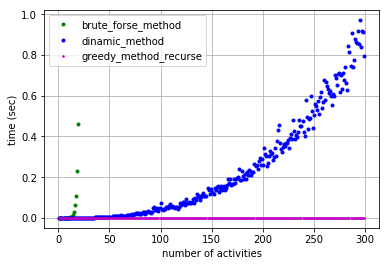

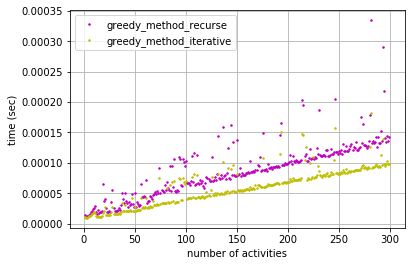

In [192]:
stats = np.array(stats)
plt.plot(stats[:,0][stats[:,1]!=0], stats[:,1][stats[:,1]!=0], 'g.', 
         label='brute_forse_method')
plt.plot(stats[:,0],stats[:,2], 'b.', label='dinamic_method')
plt.plot(stats[:,0],stats[:,3], 'm.', label='greedy_method_recurse', markersize = 3)
plt.ylabel('time (sec)')
plt.xlabel('number of activities')
plt.grid(True); plt.legend(); plt.show()

plt.plot(stats[:,0],stats[:,3], 'm.', label='greedy_method_recurse', markersize = 3)
plt.plot(stats[:,0],stats[:,4], 'y.', label='greedy_method_iterative', markersize = 3)
plt.ylabel('time (sec)')
plt.xlabel('number of activities')
plt.grid(True); plt.legend(); plt.show()

**Elements of greedy stratergy:**

1. Determine the optimal substructure of the problem.
2. Develop a recursive solution.
3. Show that if we make the greedy choice, then only one subproblem remains.
4. Prove that it is always safe to make the greedy choice. (Steps 3 and 4 can occur
in either order.)
5. Develop a recursive algorithm that implements the greedy strategy.
6. Convert the recursive algorithm to an iterative algorithm.